# Property Map Collective Variable Force Field Correction Pipeline
---
The pipeline generates force field corrections in .pdb format and is divided into these steps:

1. [Molecule shape processing](#1.-Molecule-shape-processing)
2. [Preparation of environment and molecule](#2.-Preparation-of-environment-and-molecule)
3. [Generation of representative configurations](#3.-Generation-of-representative-configurations)
4. [Accurate energy computation](#4.-Accurate-energy-computation)
5. [Inaccurate energy computation](#5.-Inaccurate-energy-computation)
6. [Define correction of force field](#6.-Define-correction-of-force-field)

In [1]:
import os
import re
import sys
import math
import time
import shutil
import subprocess

# import analytical software
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from tqdm.notebook import tqdm
from molvs import Standardizer
import nglview as nv
import pytraj as pt
import matplotlib.pyplot as plt
import gromacs as gmx
import nglview as nv

# import custom libraries
from modules.draw_3d import drawit
from modules.k8s.k8s_run import gmx_run, orca_run, parmtsnecv_run, parallel_wait

# path to orca job result check script
orca_job_check = '/opt/orcajobcheck.py'

In [ ]:
# This initializes an instance of the MDrunnerK8s class from the GROMACS Python API, specifying a custom Docker image to be used for running the GROMACS simulation
mdrun=gmx.MDrunnerK8s(image='cerit.io/ljocha/gromacs:2023-2-plumed-2-9-afed-pytorch-model-cv')

# mdrun.run(pre={'cores':ompthreads*mpiranks,'gpus':1}, mdrunargs={'deffnm':'em','ntomp':ompthreads},ncores=mpiranks)
def run(mpi=1,omp=2,gpus=1,**kwargs):
    mdrun.run(pre={'cores':omp*mpi,'mpi':mpi,'omp':omp,'gpus':gpus}, mdrunargs={**kwargs,'ntomp':omp},ncores=mpi)

In [2]:
# XXX: uff, ugly hack to avoid write-to-readonly-file errors
from modules.k8s.config import Config as k8config
!cp {k8config.PICKLE_PATH}/lock.pkl /tmp
k8config.PICKLE_PATH = '/tmp'

In [6]:
# set visualization parameters
# ... add Indices to molecule image
IPythonConsole.drawOptions.addAtomIndices = True

# ... set molecule size
IPythonConsole.molSize = 900,900

In [5]:
# convert Amber parameters to Gromacs format

!python3.9 /opt/conda/envs/pyenv/bin/acpype -p auranofin.prmtop -x auranofin.inpcrd

| ACPYPE: AnteChamber PYthon Parser interfacE v. 2022.6.6 (c) 2023 AWSdS |
Converting Amber input files to Gromacs ...
==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

Total time of execution: less than a second


In [ ]:
# convert to PDB to be loaded into RDKit

t = pt.load('auranofin.amb2gmx/auranofin_GMX.gro',top='auranofin.amb2gmx/auranofin_GMX.top')
t.save('auranofin.pdb')

In [7]:
mol = Chem.RWMol(Chem.MolFromPDBFile('auranofin.pdb',removeHs=False))

In [8]:
natoms=len(mol.GetAtoms())

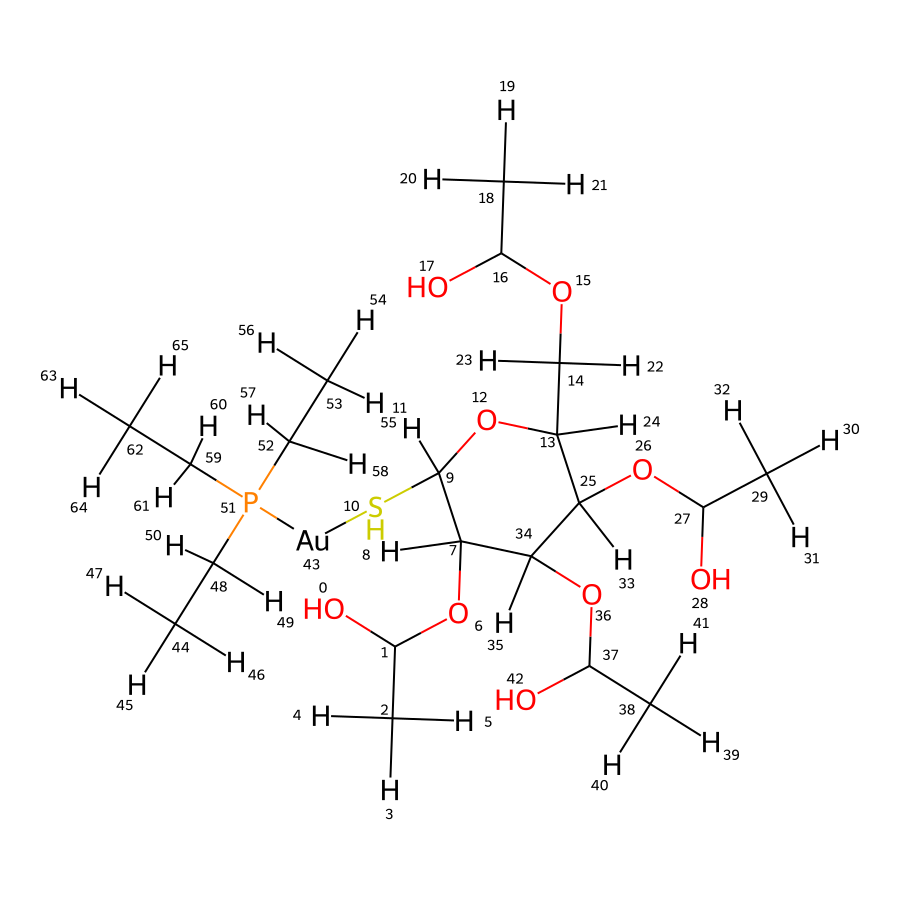

In [9]:
# XXX: add S-Au-P bonds manually

mol.AddBond(10,43)
mol.AddBond(43,51)

# cleanup and recalculation of 2D representation
Chem.SanitizeMol(mol,Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
Chem.AllChem.Compute2DCoords(mol)

mol

In [24]:
!mkdir -p em
!cp auranofin.amb2gmx/auranofin_GMX.gro auranofin.amb2gmx/auranofin_GMX.top em/

In [ ]:
workdir = 'em'
os.chdir(workdir)

In [ ]:
# prepare and run in-vacuo minimization
# gmx_run('editconf -f auranofin_GMX -o box -c -box 3 3 3', workdir='em')
gmx.editconf(f='auranofin_GMX.gro', o='box.gro', c=True, box=[3, 3, 3])

In [ ]:
# gmx_run('grompp -f em.mdp -c box -p auranofin_GMX -o em1', workdir='em')
gmx.grompp(f='em.mdp', c='box.gro', p='auranofin_GMX.top', o='em1.tpr')

In [15]:
# gmx_run('mdrun -deffnm em1', workdir='em')
run(deffnm='em1')

job.batch/gromacs-mdrun-rdtscp-16857220578161547 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16857220578161547
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

### 2.2 Perform molecular dynamics simulation
Create config file and perform molecular dynamics simulation. Simulation trajectory can be visualized.

Afterwards a [periodic boundary conditions](https://www.gromacs.org/Documentation_of_outdated_versions/Terminology/Periodic_Boundary_Conditions) must be applied so the molecule "does not jump out of the box". 

In [7]:
with open('md/md.mdp', 'w') as mdfile:
    lines = [
        'integrator          = sd',
        'nsteps              = 100000',
        'dt                  = 0.001',
        'nstxout             = 1000',
        'nstvout             = 1000',
        'nstenergy           = 1000',
        'nstlog              = 1000',
        'continuation        = no',
        'constraints         = none',
        'cutoff-scheme       = Verlet',
        'ns_type             = grid',
        'nstlist             = 1',
        'rlist               = 1.4',
        'rcoulomb            = 1.4',
        'rvdw                = 1.4',
        'coulombtype         = cut-off',
        'tcoupl              = V-rescale',
        'tc-grps             = system',
        'tau_t               = 0.1',
        'ref_t               = 300',
        'pcoupl              = no',
        'pbc                 = xyz',
        'gen_vel             = yes',
        'epsilon-r           = 80'
    ]
    mdfile.writelines(line + '\n' for line in lines)
    
shutil.copy('em/em1.gro', 'md/')
shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', 'md/')

'md/auranofin_GMX.top'

In [ ]:
workdir = 'md'
os.chdir(workdir)

In [ ]:
# gmx_run('grompp -f md.mdp -c em1 -p auranofin_GMX -o md1', workdir='md')
gmx.grompp(f='md.mdp', c='em1.gro', p='auranofin_GMX.top', o='md1.tpr')

In [ ]:
# gmx_run('mdrun -deffnm md1', workdir='md')
run(deffnm='md1')

In [ ]:
# convert trajectory to .pdb format so it can be visualized

# select group for trjconv evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
group = '0'


# gmx_run('trjconv -pbc nojump -s md1.tpr -f md1.trr -o outTraj.pdb', workdir='md', groups=group)
gmx.trjconv(s='md1.tpr',f='md1.trr',o='outTraj.pdb',pbc='nojump',input=f'{group}\n')

In [11]:
# visualize the molecular dynamics trajectory
# (currently broken)
traj = pt.load('md/outTraj.pdb')
view = nv.show_pytraj(traj)
view

NGLWidget(max_frame=100)

In [10]:
# detect rotatable bonds and corresponding representative torsions (dihedrals)

bond_smarts = ''.join(('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@',
                       '[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]'))

rotatable_bond = Chem.MolFromSmarts(bond_smarts)
rotatables = mol.GetSubstructMatches(rotatable_bond)
print(f'Rotatables: {rotatables}')

neigh = { a.GetIdx() : set() for a in mol.GetAtoms() }
for b in mol.GetBonds():
    if b.GetEndAtom().GetAtomicNum() > 1:
        neigh[b.GetBeginAtomIdx()].add(b.GetEndAtomIdx())
    if b.GetBeginAtom().GetAtomicNum() > 1:
        neigh[b.GetEndAtomIdx()].add(b.GetBeginAtomIdx())
    
    
torsions = [ ((neigh[r[0]]-{r[1]}).pop(), r[0], r[1], (neigh[r[1]]-{r[0]}).pop()) for r in rotatables]

print(f'Torsions: {torsions}')

Rotatables: ((1, 6), (6, 7), (9, 10), (13, 14), (14, 15), (15, 16), (25, 26), (26, 27), (34, 36), (36, 37), (48, 51), (51, 52), (51, 59))
Torsions: [(0, 1, 6, 7), (1, 6, 7, 9), (12, 9, 10, 43), (25, 13, 14, 15), (13, 14, 15, 16), (14, 15, 16, 17), (34, 25, 26, 27), (25, 26, 27, 28), (25, 34, 36, 37), (34, 36, 37, 42), (44, 48, 51, 59), (48, 51, 52, 53), (48, 51, 59, 62)]


In [11]:
# auranofin hack (can't do SMARTS now)
#torsions.append((9,10,43,51))
#torsions.append((10,43,51,52))
torsions.append((9,10,51,52))
torsions

[(0, 1, 6, 7),
 (1, 6, 7, 9),
 (12, 9, 10, 43),
 (25, 13, 14, 15),
 (13, 14, 15, 16),
 (14, 15, 16, 17),
 (34, 25, 26, 27),
 (25, 26, 27, 28),
 (25, 34, 36, 37),
 (34, 36, 37, 42),
 (44, 48, 51, 59),
 (48, 51, 52, 53),
 (48, 51, 59, 62),
 (9, 10, 51, 52)]

In [ ]:
# fix eventual periodic boundaries errors 

# select group for trjconv evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
group = '1'

for i in range(len(torsions)):
    fr = str(float(100-len(torsions)+i)-0.01)
    to = str(float(100-len(torsions)+i)+0.01)
    #gmx_run(f'trjconv -pbc nojump -s md1 -f md1 -o frame{i}.gro -b {fr} -e {to}<<EOF\n0\nEOF',
    #        workdir='md',
    #        groups=group)
    gmx.trjconv(s='md1.tpr',f='md1.trr',o=f'frame{i}.gro',pbc='nojump',b=fr,e=to,input=f'{group}\n')

In [9]:
# Prepare and run replica exchange metadynamics with a single earlier determined
# rotatable torsion as a CV of each replica. 
# This yields a fairly exhaustive sampling of the conformational space given
# by those torsions while still keeping the structures reasonable


with open('mtd/mtd.mdp', 'w') as mtdfile:
    lines = [
        'integrator          = sd',
        'nsteps              = 10000000',
        'dt                  = 0.001',
        'nstxout             = 10000',
        'nstvout             = 10000',
        'nstenergy           = 1000',
        'nstlog              = 1000',
        'continuation        = no',
        'constraints         = none',
        'cutoff-scheme       = Verlet',
        'ns_type             = grid',
        'nstlist             = 1',
        'rlist               = 1.4',
        'rcoulomb            = 1.4',
        'rvdw                = 1.4',
        'coulombtype         = cut-off',
        'tcoupl              = V-rescale',
        'tc-grps             = system',
        'tau_t               = 0.1',
        'ref_t               = 300',
        'pcoupl              = no',
        'pbc                 = xyz',
        'gen_vel             = yes',
        'epsilon-r           = 80'
    ]
    mtdfile.writelines(line + '\n' for line in lines)

In [10]:
for i in range(len(torsions)):
    if not os.path.exists(f'mtd/w{i}'):
        os.mkdir(f'mtd/w{i}')
        
    with open(f'mtd/w{i}/plumed.dat', "w") as plumeddat:
        plumeddat.write('RANDOM_EXCHANGES\n' +
                       f'WHOLEMOLECULES ENTITY0=1-{natoms}\n')
        for j in range(len(torsions)):
            line = f"TORSION ATOMS={','.join([str(a+1) for a in torsions[j]])} LABEL=cv{j+1}\n"
            plumeddat.write(line)
        line = ' '.join((f'METAD ARG=cv{i+1} HEIGHT=0.5 SIGMA=0.3 PACE=1000 GRID_MIN=-pi',
                         'GRID_MAX=pi BIASFACTOR=15 LABEL=be\n'))
        plumeddat.write(line)
        cvs = ""
        for j in range(len(torsions)):
            cvs = cvs + f'cv{j+1},'
        cvs = cvs[:-1]
        plumeddat.write(f'PRINT ARG={cvs} STRIDE=1000 FILE=COLVAR\n' +
                         'PRINT ARG=be.bias STRIDE=1000 FILE=BIAS\n')

In [ ]:
workdir = 'mtd'
os.chdir(workdir)

In [11]:
shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', 'mtd/')

for i in range(len(torsions)):
    shutil.copy(f'md/frame{i}.gro', f'mtd/w{i}/')
    #gmx_run(f'grompp -f mtd.mdp -c w{i}/frame{i} -p auranofin_GMX -o w{i}/mtd1',
    #        workdir='mtd',
    #        parallel=True)
    # How to do parallel=True ???
    gmx.grompp(f='mtd.mdp',c=f'w{i}/frame{i}.gro', p='auranofin_GMX.top', o=f'w{i}/mtd1.tpr')
parallel_wait()

job.batch/gromacs-grompp-rdtscp-16857212968689592 created
None
job.batch/gromacs-grompp-rdtscp-1685721298083224 created
None
job.batch/gromacs-grompp-rdtscp-16857212995632136 created
None
job.batch/gromacs-grompp-rdtscp-16857213008364723 created
None
job.batch/gromacs-grompp-rdtscp-16857213020333993 created
None
job.batch/gromacs-grompp-rdtscp-16857213035405562 created
None
job.batch/gromacs-grompp-rdtscp-168572130465299 created
None
job.batch/gromacs-grompp-rdtscp-1685721306140287 created
None
job.batch/gromacs-grompp-rdtscp-16857213076330912 created
None
job.batch/gromacs-grompp-rdtscp-1685721308936504 created
None
job.batch/gromacs-grompp-rdtscp-16857213101394608 created
None
job.batch/gromacs-grompp-rdtscp-1685721311259515 created
None
job.batch/gromacs-grompp-rdtscp-16857213124383688 created
None
job.batch/gromacs-grompp-rdtscp-1685721313943402 created
None


Waiting for job(s) with label gromacs-grompp-rdtscp-16857212968689592
Waiting for 14 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [12]:
directories = ''
for i in range(len(torsions)):
    directories = directories + f'w{i} '

# ???
gmx_run(f'mdrun -g mdrunlog -deffnm mtd1 -replex 500 -plumed plumed.dat -multidir {directories}', 
        workdir='mtd', 
        mpi_run=len(torsions))

job.batch/gromacs-mdrun-rdtscp-16857230592290523 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16857230592290523
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/gromacs/gmx-chooser.sh: line 39: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/gromacs/gmx-chooser.sh: line 39: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/gromacs/gmx-chooser.sh: line 39: grep: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
/gromacs/gmx-c

### 3.2 Configurations clustering
Concatinate all the trajectories that simulation produced. Then cluster this trajectory to groups for which one representative configuration is chosen (*cutoff* can be modified for more/less clusters).

Result of [Gromacs clustering](https://manual.gromacs.org/documentation/current/onlinehelp/gmx-cluster.html) is .pdb file containing all representative configurations. These must be divided into separate .pdb files for further processing.

In [17]:
#trajectories = ''
#for i in range(len(torsions)):
#    trajectories = trajectories + f'mtd/w{i}/mtd1.trr '

# concatinate trajectories    
#gmx_run(f'trjcat -f {trajectories} -cat -o mtd/mtd1.trr')

# Create a list of trajectory files
trajectories = [f'mtd/w{i}/mtd1.trr' for i in range(len(torsions))]

gmx.trjcat(f=trajectories, o='mtd/mtd1.trr')

# make index file with non-hydrogen atoms
#gmx_run("make_ndx -f md/md1.tpr -o mtd/index.ndx", make_ndx="1&!aH*")
make_ndx_input = "1&!aH*"
gmx.make_ndx(f='md/md1.tpr', o='mtd/index.ndx', input=f'{make_ndx_input}\nq\n')

job.batch/gromacs-trjcat-rdtscp-16857239117059662 created


Waiting for job(s) with label gromacs-trjcat-rdtscp-16857239117059662
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjcat, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-make-ndx-rdtscp-16857239203493924
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx make_ndx, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [19]:
# select groups for cluster evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)

groups = '50'
#groups = '30'

!mkdir -p clustering

# gmx_run('''cluster -method gromos -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -n mtd/index.ndx -cutoff 0.15 \
#           -cl clustering/outClusters.pdb''', groups=groups)
gmx.cluster(method='gromos',f='mtd/mtd1.trr',s='mtd/w0/mtd1.tpr',n='mtd/index.ndx',cutoff=0.15,cl='clustering/outClusters.pdb',input=f'{groups}\n')

job.batch/gromacs-cluster-rdtscp-1685724439363012 created


Waiting for job(s) with label gromacs-cluster-rdtscp-1685724439363012
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx cluster, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [20]:
# divide all clusters from clustering output file 
# to single files and index them from 0.
# Also fix missing element of each ATOM on 
# line 77 (by pdb format specification)
cluster_index = 0
i = 0

!mkdir clustering/outClustersPDB
with open('clustering/outClusters.pdb') as infile:
    clusters = infile.readlines()
    while i < len(clusters):
        with open(f'clustering/outClustersPDB/outCluster{cluster_index}.pdb', 'w') as outfile:
            for line in clusters[i:]:
                split_line = line.split()
                if split_line[0] == 'ATOM':
                    line = line[:77] + split_line[2][0] + '\n'
                outfile.write(line)
                i += 1
                if line == 'ENDMDL\n':
                    break
            cluster_index += 1

### 3.3 Visualize landmarks
Goal of this part is to compute embeddings which are visualized afterwards. Each step is performed on the trajectory which results from previous step. Base trajectory used in 1st step is the concatinated trajectory from metadynamics simulation.

1. Apply periodic boundary conditions to metadynamics trajectory
2. Perform fitting on the trajectory
3. Remove Hydrogen
4. Train [parmtSNEcv](https://gitlab.ics.muni.cz/spiwokv/parmtSNEcv)
5. Compute embeddings

Finally visualize all generated configurations from metadynamics trajectory in contrast to representative clusters configurations

In [59]:
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)
# select group for periodic boundaries check output:
group = '0'
# gmx_run('trjconv -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -pbc mol -o visualization/traj/mtd1_nopbc.xtc', groups=group)
gmx.trjconv(f='mtd/mtd1.trr',s='mtd/w0/mtd1.tpr',pbc='mol',o='visualization/traj/mtd1_nopbc.xtc',input=f'{group}\n')

job.batch/gromacs-trjconv-rdtscp-16851142276367471 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16851142276367471
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [60]:
# select groups for fitting and output:
groups = '00'
#gmx_run('''trjconv -f visualization/traj/mtd1_nopbc.xtc -s clustering/outClustersPDB/outCluster0.pdb \

# gmx_run('''trjconv -f visualization/traj/mtd1_nopbc.xtc -s mtd/w0/mtd1.tpr \
#           -fit rot+trans -o visualization/traj/mtd1_fit.xtc''', groups=groups)
gmx.trjconv(f='visualization/traj/mtd1_nopbc.xtc',s='mtd/w0/mtd1.tpr',fit='rot+trans',o='visualization/traj/mtd1_fit.xtc',input=f'{groups}\n')

job.batch/gromacs-trjconv-rdtscp-16851142393054013 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16851142393054013
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [61]:
# select group for no Hydrogen output:
#group = '3'
group = '5'
#gmx_run('trjconv -f visualization/traj/mtd1_fit.xtc -n mtd/index.ndx -o visualization/traj/mtd1_fit_noH.xtc',
#        groups=group)
gmx.trjconv(f='visualization/traj/mtd1_fit.xtc',n='mtd/index.ndx',o='visualization/traj/mtd1_fit_noH.xtc',input=f'{group}\n')

job.batch/gromacs-trjconv-rdtscp-16851142534389272 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16851142534389272
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [62]:
# select groups for size of the box and output:
#groups = '33'
groups = '55'
# gmx_run('''editconf -f clustering/outClustersPDB/outCluster0.pdb -n mtd/index.ndx -box 3 3 3 -c \
#           -o visualization/ref.pdb''', groups=groups)
gmx.editconf(f='clustering/outClustersPDB/outCluster0.pdb',n='mtd/index.ndx',box=[3, 3, 3],c=True,o='visualization/ref.pdb',input=f'{groups}\n')

job.batch/gromacs-editconf-rdtscp-16851142627652664 created


Waiting for job(s) with label gromacs-editconf-rdtscp-16851142627652664
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [63]:
# fix weights of atoms
data = ''
with open('visualization/ref.pdb', 'r') as infile:
    data = infile.read()
    data = data.replace('0.00', '1.00')
with open('visualization/ref.pdb', 'w') as outfile:
    outfile.writelines(data)

In [64]:
# train parmtSNEcv
parmtsnecv_run('''parmtSNEcv -i traj/mtd1_fit_noH.xtc -p ref.pdb -boxx 3 -boxy 3 -boxz 3 \
               -dim 2 -layers 2 -o out.txt -plumed plumed.dat -epochs 500''', workdir='visualization')
#               -dim 2 -layers 2 -o out.txt -plumed plumed.dat -epochs 2000''', workdir='visualization')

job.batch/parmtsnecv-parmtsnecv-rdtscp-16851142741354544 created


Waiting for job(s) with label parmtsnecv-parmtsnecv-rdtscp-16851142741354544
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


Using TensorFlow backend.
2023-05-26 15:18:17.437590: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-05-26 15:18:17.464641: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2794650000 Hz
2023-05-26 15:18:17.468576: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559bef9a2c60 executing computations on platform Host. Devices:
2023-05-26 15:18:17.468605: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
Loading trajectory
Fitting trajectory
<mdtraj.Trajectory with 7670 frames, 32 atoms, 3 residues, and unitcells> succesfully loaded and fitted

box size set to  3.000 x  3.000 x  3.000 nm

Building model
Training model
Computing pairwise distances...
Computing P-values for point 0 of 7670...
Computing P-values for point 500 of 7670...
Computing P-values for point 1000 of 7670...
Computing P-values f

In [65]:
# modify plumed.dat to compute embedding in every step (100->1) 
# and change the name of file for *** mtd trajectory ***
with open('visualization/plumed.dat', 'r') as infile:
    data = infile.read()
    data = data.replace('STRIDE=100', 'STRIDE=1')
    data = data.replace('COLVAR', '2d_embedding')
with open('visualization/plumed.dat', 'w') as outfile:
    outfile.writelines(data)

In [66]:
# run with plumed
gmx_run('driver --plumed plumed.dat --mf_xtc traj/mtd1_fit.xtc', workdir='visualization')

job.batch/gromacs-driver-rdtscp-1685116052950987 created


Waiting for job(s) with label gromacs-driver-rdtscp-1685116052950987
Waiting for 1 jobs to complete
Using namespace mff-prod-ns
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
# modify plumed.dat to compute embedding in every step and change name of file for *** representatives ***
with open('visualization/plumed.dat', 'r') as infile:
    data = infile.read()
    data = data.replace('2d_embedding', 'landmarks')
with open('visualization/plumed.dat', 'w') as outfile:
    outfile.writelines(data)

In [68]:
# run with plumed
shutil.copy('clustering/outClusters.pdb', 'visualization/')
gmx_run('driver --plumed plumed.dat --mf_pdb outClusters.pdb', workdir='visualization')

job.batch/gromacs-driver-rdtscp-16851161024296381 created


Waiting for job(s) with label gromacs-driver-rdtscp-16851161024296381
Waiting for 1 jobs to complete
Using namespace mff-prod-ns
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



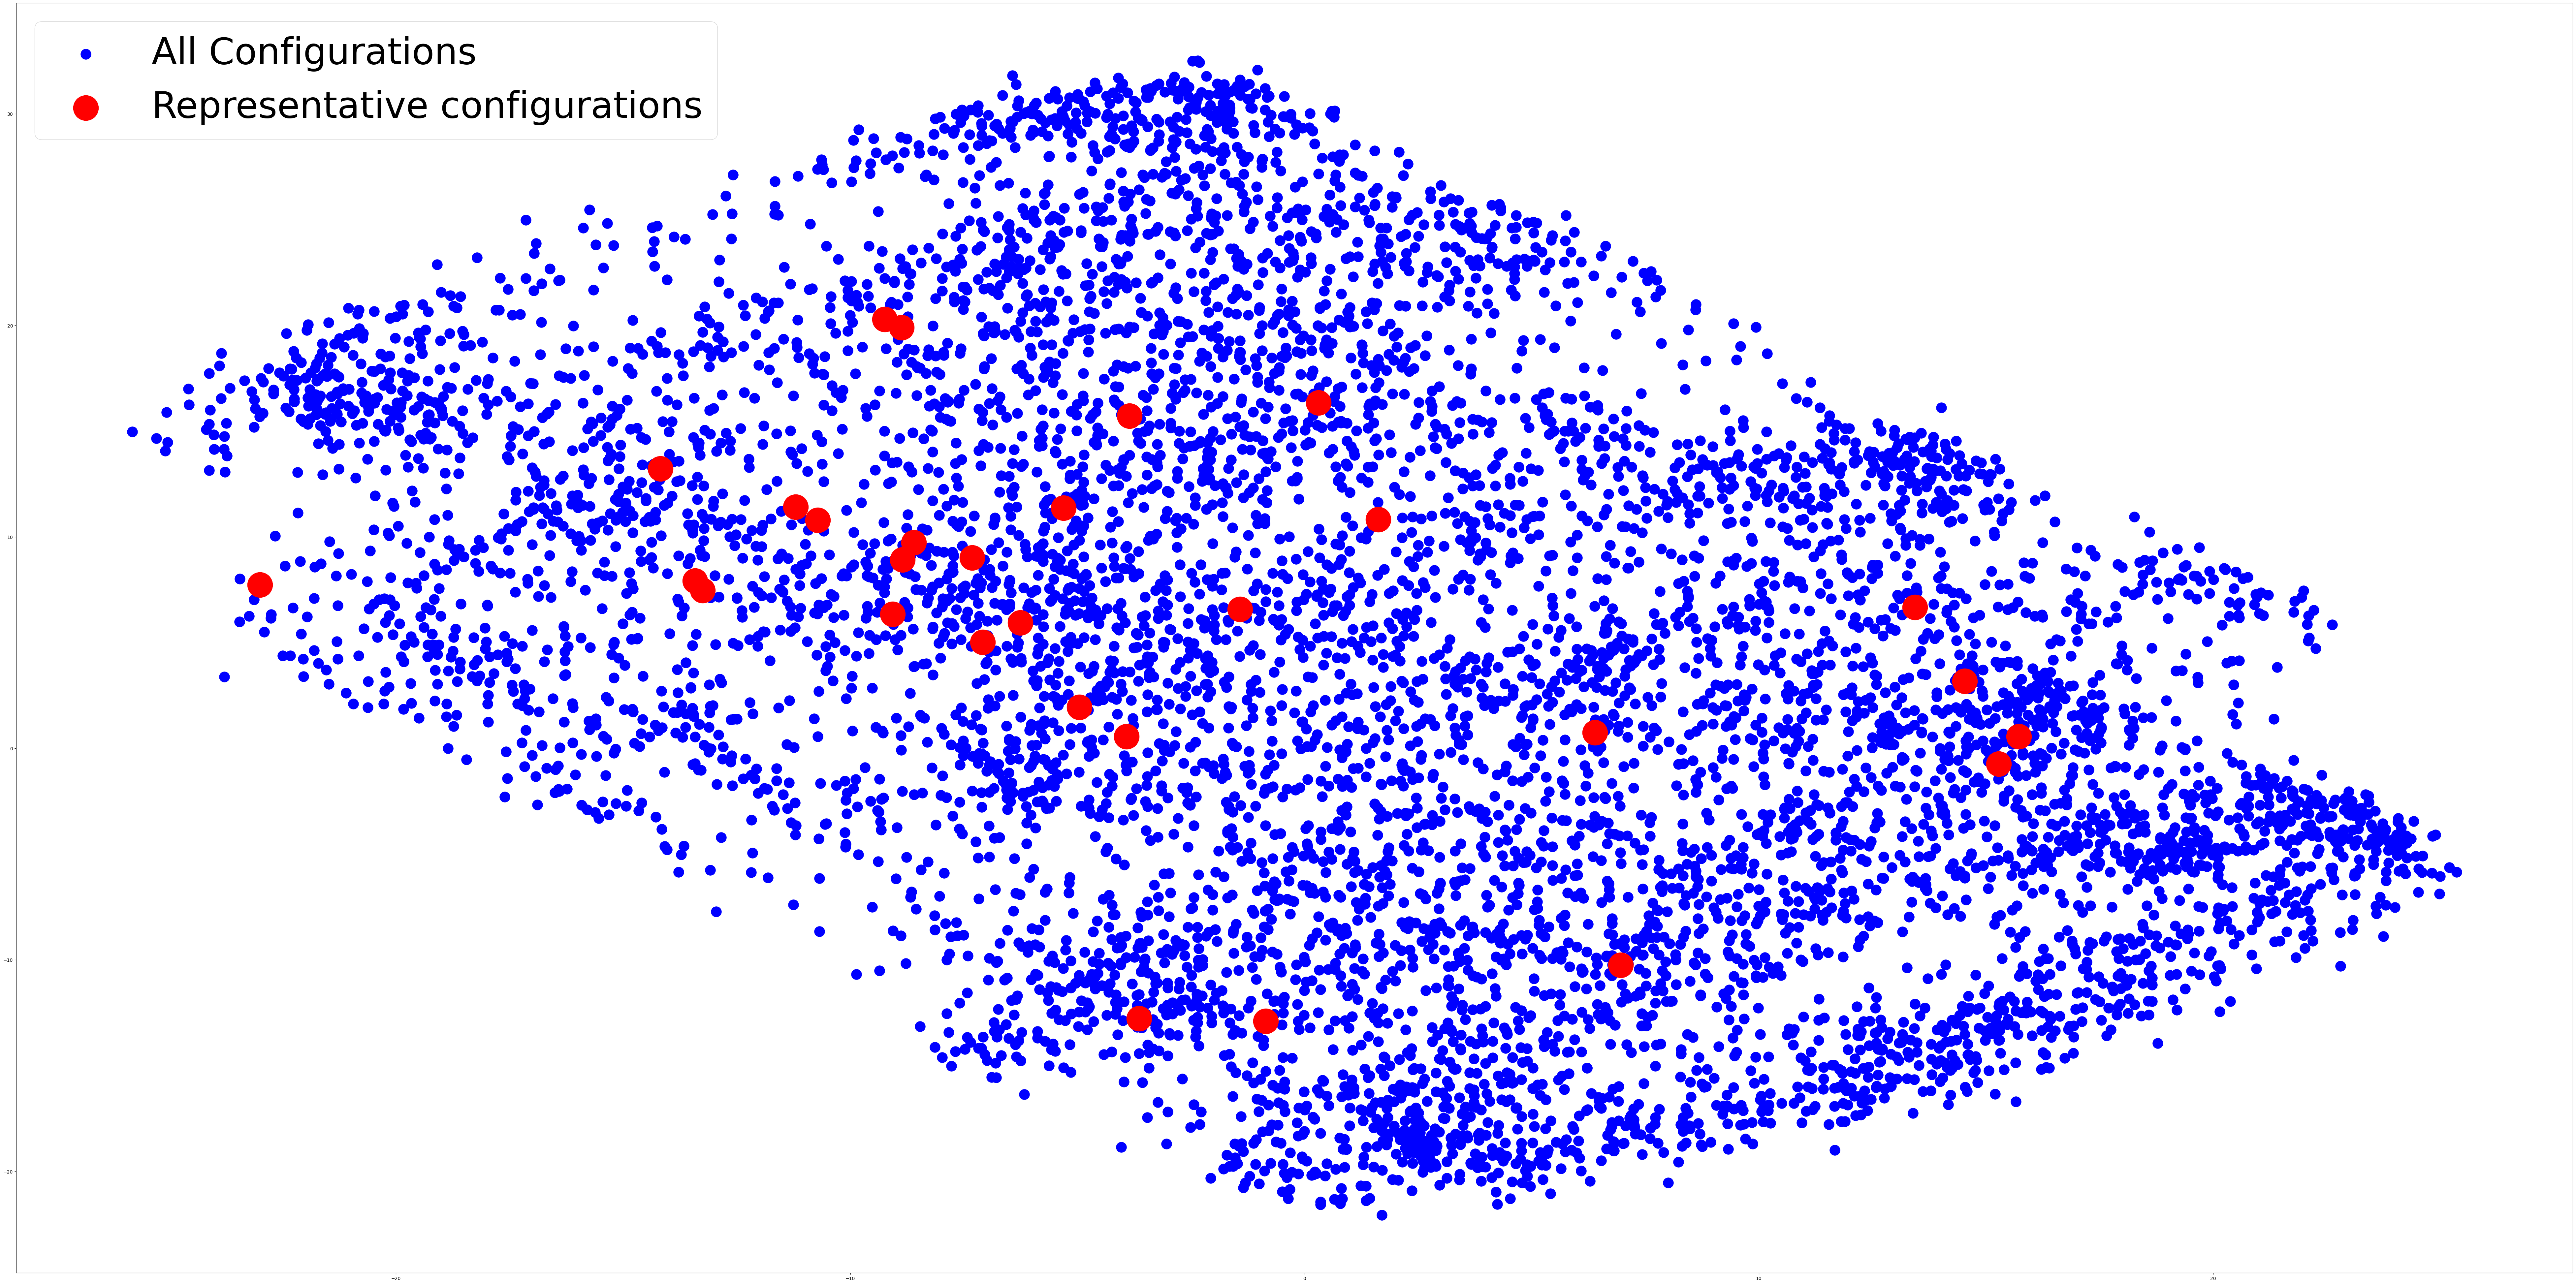

In [26]:
# visualize configurations in contrast to representative configurations

x = []
y = []
x1 = []
y1 = []
with open("visualization/2d_embedding", "r") as infile:
    for line in infile.readlines()[1:]:
        split_values = line.split()
        x.append(float(split_values[1]))
        y.append(float(split_values[2]))
with open("visualization/landmarks", "r") as infile:
    for line in infile.readlines()[1:]:
        split_values = line.split()
        x1.append(float(split_values[1]))
        y1.append(float(split_values[2]))
        
        
plt.figure(figsize=(100, 50), dpi=100)
plt.scatter(x, y, c='b', marker='.', label='All Configurations', s=2000)
plt.scatter(x1, y1, c='r', marker='o', label='Representative configurations', s=3000)
plt.legend(loc='upper left', prop={'size': 80})

plt.show()

## 4. Accurate energy computation

**Changed to xTB2 - BP86 - TPSSh - b2plyp** according to Martin Krupicka recommendations. **in progress**

**Accurate energy** values are computed in this step using the [Orca](https://sites.google.com/site/orcainputlibrary/) quantum chemistry software. Orca uses [method files](https://sites.google.com/site/orcainputlibrary/generalinput) in exact format to perform the computations. Computation of exact energy values of each representative is composed of 3-step chain. Input for *AM1* are representative configurations defined by clustering in previous step. Each next computation is performed on the output of the previous step.

1. **AM1 optimisation** (*input*: clustering results)
2. **BP86 SVP** (*input*: AM1 output)
3. **BP86 TZVP** (*input*: BP86 SVP output, *output*: exact energy values of representative configurations)

Also each step above consists of 3 substeps:

1. Convert the output of previous step to Orca compatible *.inp method*
2. Perform Orca computation
3. Analyse output (see logs)

You can view the current state of Orca calculation in output logs (3rd substep) with for example *\"tail -f XXX\"* command. Please read the wrapper [documentation](https://github.com/CERIT-SC/pmcvff-correction/tree/jupyter-refactor/modules/k8s) before interacting with any Orca command.

In [21]:
# initialize a list of all clusters that are considered
# in the quantum chemistry computations. For example
# non-converged simulation on cluster will result in
# discarding that cluster from further computations
#
# ** don't forget to reset clusters variable when
# rerunning computations as non-converged will be
# missing **
clusters = []
for cluster in os.listdir('clustering/outClustersPDB'):
    if '.pdb' in cluster:
        clusters.append(cluster.replace('.pdb', ''))
clusters        

['outCluster11',
 'outCluster0',
 'outCluster12',
 'outCluster10',
 'outCluster19',
 'outCluster8',
 'outCluster4',
 'outCluster15',
 'outCluster9',
 'outCluster6',
 'outCluster21',
 'outCluster13',
 'outCluster1',
 'outCluster22',
 'outCluster5',
 'outCluster17',
 'outCluster7',
 'outCluster20',
 'outCluster24',
 'outCluster3',
 'outCluster23',
 'outCluster2',
 'outCluster16',
 'outCluster14',
 'outCluster18']

In [11]:
# convert .pdb file to orca method
# - method specifies which method to apply by Orca
# - info is to specify the *charge* and *spin* of molecule
# - nprocs is to specify the number of CPU's to use (None for default)
# - xyz specify True to convert .xyz to orca instead
def pdb2orca(pdb_in, orca_out, method, info, nprocs=4, xyz=False):
    with open(pdb_in, 'r') as infile, open(orca_out, 'w') as outfile:
        outfile.write(f'{method}\n')
        
        if nprocs:
            outfile.write(f'%pal\n' +
                          f'nprocs {str(nprocs)}\n' +
                          f'end\n')
            outfile.write(f'%maxcore {32 // nprocs}000\n')
            
        outfile.write('%geom\n' +
                      'Constraints\n')
        
        # write torsions
        for torsions_list in torsions:
            outfile.write('{D ' +
                          ' '.join(str(x) for x in torsions_list) +
                          'C}\n')
        
        outfile.write('end\n' + 
                      'end\n\n' +
                     f'*xyz {info[0]} {info[1]}\n')
        
        # copy atom information from input and modify
        # to fit the orca method format
        if xyz:
            for line in infile.readlines()[2:]:
                outfile.write(f'{line}')
        else:
            for line in infile.readlines():
                splitline = line.split()
                if splitline[0] == 'ATOM':
                    atom = splitline[10]
                    if atom == 'A': # auranofin
                        atom = 'Au'
                    else:
                        atom = atom + ' '
                    orca_line = f'{atom}      {splitline[5]}      {splitline[6]}       {splitline[7]}\n'
                    outfile.write(orca_line)
                
        outfile.write('*\n')

In [14]:
charge=Chem.rdmolops.GetFormalCharge(mol)
charge

0

In [19]:
# xTB2 first

method = '!xtb2 Opt'


# input directory of .pdb representatives
input_dir = 'clustering/outClustersPDB/'

# output directory where converted .inp Orca 
# methods will be placed
output_dir = 'xtb2/input/'
!mkdir -p {output_dir}

# specify spin (and charge)
spin = 1
# charge is specified in the first step 
# of 1. Molecule shape processing
# charge = XXX


for pdb in os.listdir(input_dir):
    if '.pdb' in pdb:
        infile = input_dir + pdb
        outfile = output_dir + pdb.replace('pdb', 'inp')

        pdb2orca(infile, outfile, method, (charge,spin))
        
        

In [15]:
input_path = "xtb2/input/"
output_path = "xtb2/output/"
!mkdir -p {output_path}

In [26]:
for method_file in os.listdir(input_path):
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        #orca_run(method_file, cluster_dir_path + log_file, workdir=cluster_dir_path, parallel=True)
        orca_run(method_file, log_file, workdir=cluster_dir_path, parallel=True)
    
parallel_wait()

mkdir -p /tmp/orca && cp /share/xtb2/output/outCluster20//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster20.inp > outCluster20.out; cp /tmp/orca/* /share/xtb2/output/outCluster20/
xtb2/output/outCluster20//outCluster20.inp
job.batch/orca-orca-rdtscp-16857266002456563 created
None
mkdir -p /tmp/orca && cp /share/xtb2/output/outCluster11//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster11.inp > outCluster11.out; cp /tmp/orca/* /share/xtb2/output/outCluster11/
xtb2/output/outCluster11//outCluster11.inp
job.batch/orca-orca-rdtscp-16857266018166308 created
None
mkdir -p /tmp/orca && cp /share/xtb2/output/outCluster7//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster7.inp > outCluster7.out; cp /tmp/orca/* /share/xtb2/output/outCluster7/
xtb2/output/outCluster7//outCluster7.inp
job.batch/orca-orca-rdtscp-1685726602993709 created
None
mkdir -p /tmp/orca && cp /share/xtb2/output/outCluster2//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster2.inp > outCluster2.out;

Waiting for job(s) with label orca-orca-rdtscp-16857266002456563
Waiting for 25 jobs to complete
Using namespace mff-prod-ns
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
number_of_clusters = len(clusters)

for cluster in clusters:
    log_file = f'{output_path}{cluster}/{cluster}.out'
    try:
        with open(log_file) as infile:
            log = infile.read()
            if 'FINAL SINGLE POINT ENERGY' not in log:
                !{orca_job_check} {log_file}
                clusters.remove(cluster)
    except FileNotFoundError:
        clusters.remove(cluster)

clusters            

['outCluster11',
 'outCluster0',
 'outCluster12',
 'outCluster10',
 'outCluster19',
 'outCluster8',
 'outCluster4',
 'outCluster15',
 'outCluster9',
 'outCluster6',
 'outCluster21',
 'outCluster13',
 'outCluster1',
 'outCluster22',
 'outCluster5',
 'outCluster17',
 'outCluster7',
 'outCluster20',
 'outCluster24',
 'outCluster3',
 'outCluster23',
 'outCluster2',
 'outCluster16',
 'outCluster14',
 'outCluster18']

In [17]:
orca_energies = {}

for cluster in clusters:
    with open(f'{output_path}{cluster}/{cluster}.out') as infile:
        for line in reversed(list(infile)):
            energy_list = re.findall(r'(FINAL SINGLE POINT ENERGY)( +)(-?\d+\.\d+)', line)
            if len(energy_list) > 0:
                orca_energies[cluster] = float(energy_list[0][2])
                break

In [18]:
CONVERSION_CONST = 2625.499638
min_energy = min(list(orca_energies.values()))

for cluster, energy in orca_energies.items():
    orca_energies[cluster] = (energy-min_energy)*CONVERSION_CONST
    
orca_energies

{'outCluster11': 25.90319360620412,
 'outCluster0': 13.43449137767917,
 'outCluster12': 12.407551296362957,
 'outCluster10': 15.753553409980656,
 'outCluster19': 58.399963033513835,
 'outCluster8': 35.945677552890565,
 'outCluster4': 19.397354631603964,
 'outCluster15': 28.024068669359277,
 'outCluster9': 31.56241711813572,
 'outCluster6': 15.39074485676162,
 'outCluster21': 40.03905315946517,
 'outCluster13': 30.99201217261938,
 'outCluster1': 0.0,
 'outCluster22': 26.575899254740957,
 'outCluster5': 20.496002201508638,
 'outCluster17': 11.543427059240255,
 'outCluster7': 26.46545267653187,
 'outCluster20': 39.504187292129714,
 'outCluster24': 30.89907515652839,
 'outCluster3': 39.02473456380033,
 'outCluster23': 23.10310808788912,
 'outCluster2': 36.50859410080345,
 'outCluster16': 20.59070995961939,
 'outCluster14': 52.60708378911036,
 'outCluster18': 32.808268051141965}

In [31]:
# Try b2plyp directly


method = '!b2plyp RIJCOSX def2-tzvpp def2/J def2-tzvp/C Opt'


# input directory of .pdb representatives
input_dir = 'clustering/outClustersPDB/'

# output directory where converted .inp Orca 
# methods will be placed
output_dir = 'b2plyp/input/'
!mkdir -p {output_dir}

# specify spin (and charge)
spin = 1
# charge is specified in the first step 
# of 1. Molecule shape processing
# charge = XXX


for pdb in os.listdir(input_dir):
    if '.pdb' in pdb:
        infile = input_dir + pdb
        outfile = output_dir + pdb.replace('pdb', 'inp')

        pdb2orca(infile, outfile, method, (charge,spin))

In [19]:
input_path = "b2plyp/input/"
output_path = "b2plyp/output/"
!mkdir -p {output_path}

In [ ]:
for method_file in os.listdir(input_path):
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        orca_run(method_file, log_file, workdir=cluster_dir_path, parallel=True)
    
parallel_wait()

mkdir -p /tmp/orca && cp /share/b2plyp/output/outCluster20//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster20.inp > outCluster20.out; cp /tmp/orca/* /share/b2plyp/output/outCluster20/
b2plyp/output/outCluster20//outCluster20.inp
job.batch/orca-orca-rdtscp-16857270405431972 created
None
mkdir -p /tmp/orca && cp /share/b2plyp/output/outCluster11//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster11.inp > outCluster11.out; cp /tmp/orca/* /share/b2plyp/output/outCluster11/
b2plyp/output/outCluster11//outCluster11.inp
job.batch/orca-orca-rdtscp-16857270420415497 created
None
mkdir -p /tmp/orca && cp /share/b2plyp/output/outCluster7//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster7.inp > outCluster7.out; cp /tmp/orca/* /share/b2plyp/output/outCluster7/
b2plyp/output/outCluster7//outCluster7.inp
job.batch/orca-orca-rdtscp-16857270432639968 created
None
mkdir -p /tmp/orca && cp /share/b2plyp/output/outCluster2//* /tmp/orca && cd /tmp/orca && /opt/orca/orca outCluster2.i

Waiting for job(s) with label orca-orca-rdtscp-16857270405431972
Waiting for 25 jobs to complete
Using namespace mff-prod-ns


In [20]:
# check output && discard non-converging clusters
number_of_clusters = len(clusters)

for cluster in clusters:
    log_file = f'{output_path}{cluster}/{cluster}.out'
    with open(log_file) as infile:
        log = infile.read()
        if '****ORCA TERMINATED NORMALLY****' not in log:
            !{orca_job_check} {log_file}
            clusters.remove(cluster)

print(f'''{len(clusters)}/{number_of_clusters} successfully converged - unconverged are not considered
           in next steps.\n You can view logs at "{output_path}" directory''')

filename is b2plyp/output/outCluster9/outCluster9.out

ORCA JobCheck Utility version 3.0 (Python3 version) 
-----------------------------------------------------------------------
File: b2plyp/output/outCluster9/outCluster9.out 
ORCA version 5.0.1 ran 4 MPI-process job.
ORCA has not terminated with message and may still be running this job 

66 atoms. Charge: 0  Spin: 0.0  Contracted basis functions: 1515
Initial orbitals via Guess
Optimization may still be running 
Optimization Cycle 59 energy: -2334.131038875004
        ----------------------|Geometry convergence|-------------------------
        Item                value                   Tolerance       Converged
        ---------------------------------------------------------------------
        Energy change       0.0006587424            0.0000050000      NO
        RMS gradient        0.0008974097            0.0001000000      NO
        MAX gradient        0.0046759844            0.0003000000      NO
        RMS step           

In [22]:
# instead of previous cell, we may be interested in intermediate results

number_of_clusters = len(clusters)

for cluster in clusters:
    log_file = f'{output_path}{cluster}/{cluster}.out'
    try:
        with open(log_file) as infile:
            log = infile.read()
            if 'FINAL SINGLE POINT ENERGY' not in log:
                !{orca_job_check} {log_file}
                clusters.remove(cluster)
    except FileNotFoundError:
        clusters.remove(cluster)

clusters            

['outCluster11',
 'outCluster0',
 'outCluster12',
 'outCluster10',
 'outCluster19',
 'outCluster8',
 'outCluster4',
 'outCluster15',
 'outCluster9',
 'outCluster6',
 'outCluster21',
 'outCluster13',
 'outCluster1',
 'outCluster22',
 'outCluster5',
 'outCluster17',
 'outCluster7',
 'outCluster20',
 'outCluster24',
 'outCluster3',
 'outCluster23',
 'outCluster2',
 'outCluster16',
 'outCluster14',
 'outCluster18']

In [81]:
# extract final energies from output of Orca TZVP method
# note: energies are in hartree unit
orca_energies = {}

for cluster in clusters:
    with open(f'{output_path}{cluster}/{cluster}.out') as infile:
        for line in reversed(list(infile)):
            energy_list = re.findall(r'(FINAL SINGLE POINT ENERGY)( +)(-?\d+\.\d+)', line)
            if len(energy_list) > 0:
                orca_energies[cluster] = float(energy_list[0][2])
                break

In [82]:
# convert from hartree to kJ/mol

CONVERSION_CONST = 2625.499638
min_energy = min(list(orca_energies.values()))

for cluster, energy in orca_energies.items():
    orca_energies[cluster] = (energy-min_energy)*CONVERSION_CONST
    
orca_energies

{'outCluster11': 10.136624066159886,
 'outCluster0': 9.072813808019363,
 'outCluster12': 9.106465600921283,
 'outCluster10': 17.155652562538663,
 'outCluster19': 73.52046247424472,
 'outCluster8': 13.08088474601164,
 'outCluster4': 22.67910175872164,
 'outCluster15': 37.83981410708109,
 'outCluster9': 4.737594938502009,
 'outCluster6': 21.272211152680786,
 'outCluster21': 35.17584614780066,
 'outCluster13': 47.309419875242966,
 'outCluster1': 1.059961783205897,
 'outCluster22': 68.64769656703379,
 'outCluster5': 32.054600111899234,
 'outCluster17': 27.47243619098727,
 'outCluster7': 0.0,
 'outCluster20': 53.954926299404434,
 'outCluster24': 20.332655053301213,
 'outCluster3': 46.15568595422845,
 'outCluster23': 20.98690716206865,
 'outCluster2': 41.01026540915279,
 'outCluster16': 15.871336865120757,
 'outCluster14': 17.934761328701146,
 'outCluster18': 22.80218470630036}

## 5. Inaccurate energy computation
**Inaccurate energy** values are computed via Gromacs. To compute energy values we use structures whose geometry was optimised by Orca. Afterwards dihedrals are computed from optimised structures' trajectory by [Plumed](https://www.plumed.org/). Finally using dihedrals compute inaccurate energy values.

### 5.1 Convert optimised .xyz files to .pdb format
Convert optimised structures to corresponding *.pdb* files by combining information about atoms from cluster representative *.pdb* file and xyz coordinates from optimised *.xyz* file. 

In [68]:
#input_dir = 'bp86tzvp/output/'
input_dir = 'b2plyp/output/'
output_dir = 'pdb_opt/'
!mkdir -p {output_dir}

In [69]:
# get information about atoms from cluster representative
# (frist 26 columns - see .pdb format details for details)
atoms = []
with open('clustering/outClustersPDB/outCluster0.pdb', 'r') as infile:
    for line in infile.readlines():
            if "ATOM" in line:
                atoms.append(line[:26])

                
# combine atoms from .pdb with optimised coordinates from .xyz
for cluster in clusters:
    with open(f'{input_dir}{cluster}/{cluster}.xyz', 'r') as infile, \
         open(f'{output_dir}{cluster}_opt.pdb', 'w') as outfile:
        xyz = infile.readlines()[2:]
        for i in range(len(atoms)):
            split_line = xyz[i].split()
            
            # fix spaces near numbers with '-' to fit .pdb format
            # and print only 3 decimal places
            for j in range(1, len(split_line)):
                split_line[j] = f'{round(float(split_line[j]), 3):.3f}'
                if split_line[j][0] != '-':
                    split_line[j] = f' {split_line[j]}'
            pdb_line = f'{atoms[i]}     {split_line[1]}  {split_line[2]}  {split_line[3]}  1.00  0.00\n'
            outfile.write(pdb_line)

### 5.2 Compute dihedrals

In [70]:
refine_torsions = torsions[:-1]

# auranofin: fix also S-Au and P-Au

refine_torsions.append((9,10,43,51))
refine_torsions.append((10,43,51,52))



In [71]:
torsions

[(0, 1, 6, 7),
 (1, 6, 7, 9),
 (12, 9, 10, 43),
 (25, 13, 14, 15),
 (13, 14, 15, 16),
 (14, 15, 16, 17),
 (34, 25, 26, 27),
 (25, 26, 27, 28),
 (25, 34, 36, 37),
 (34, 36, 37, 42),
 (44, 48, 51, 59),
 (48, 51, 52, 53),
 (48, 51, 59, 62),
 (9, 10, 51, 52)]

In [72]:
refine_torsions

[(0, 1, 6, 7),
 (1, 6, 7, 9),
 (12, 9, 10, 43),
 (25, 13, 14, 15),
 (13, 14, 15, 16),
 (14, 15, 16, 17),
 (34, 25, 26, 27),
 (25, 26, 27, 28),
 (25, 34, 36, 37),
 (34, 36, 37, 42),
 (44, 48, 51, 59),
 (48, 51, 52, 53),
 (48, 51, 59, 62),
 (9, 10, 43, 51),
 (10, 43, 51, 52)]

In [73]:
# concatinate optimised structures to a trajectory
# so it can be processed by Plumed
with open('clusters_opt.pdb', 'w') as outfile:
    for cluster in clusters:
        outfile.write(f'MODEL {cluster[len(cluster)-1]}\n')
        with open(f'pdb_opt/{cluster}_opt.pdb', 'r') as infile:
            outfile.write(infile.read())
            outfile.write('ENDMDL\n')


# create plumed file for Plumed processing
with open('plumed.dat', 'w') as infile:
    cvs = []
    infile.write(f'WHOLEMOLECULES ENTITY0=1-{str(natoms)}\n')
    for i in range(0, len(refine_torsions)):
        cvs.append(f'cv{i}')
        delimeted_torsions = ','.join(str(x+1) for x in refine_torsions[i])  # XXX +1 
        infile.write(f'TORSION ATOMS={delimeted_torsions} LABEL={cvs[i]}\n')
    cvs = ','.join(cvs)
    infile.write(f'PRINT ARG={cvs} STRIDE=1 FILE=DIHEDRALS')
    

# compute dihedrals (produces output file DIHEDRALS)
gmx_run(f'driver --plumed plumed.dat --mf_pdb clusters_opt.pdb')

job.batch/gromacs-driver-rdtscp-16867416332141418 created


Waiting for job(s) with label gromacs-driver-rdtscp-16867416332141418
Waiting for 1 jobs to complete
Using namespace mff-prod-ns



DRIVER: Found molfile format trajectory pdb with name clusters_opt.pdb
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: e40a0ed94) compiled on Feb 23 2021 at 14:51:32
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/lib/plumed
PLUMED: For installed feature, see /usr/local/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 66
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action WHOLEMOLECULES
PLUMED:   with label @0
PLUMED:   with stride 1
PLUMED:   atoms in entity 0 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 
PLUMED: Action TORSION
PLUMED:   with la

In [74]:
# remove all # lines, keep only numbers
lines = []
with open("DIHEDRALS", "r") as ifile:
    for line in ifile.readlines():
        if "#" not in line:
            lines.append(line)
with open("DIHEDRALS", "w") as ofile:
    for line in lines:
        ofile.write(line)

### 5.3 Compute inaccurate energy values

In [86]:

cvs = {c : [] for c in clusters }
with open('DIHEDRALS','r') as infile:
    dihedrals = infile.readlines()
    for i in range(len(dihedrals)):
        t_angles = dihedrals[i].split()
        for j in range(len(refine_torsions)):
            cvs[clusters[i]].append(float(t_angles[j+1])*(180/math.pi))

            
def generate_restraint(cluster):
    wrote=False
#    with open('MOL.amb2gmx/MOL_GMX.top', 'r') as infile, \
    with open('auranofin.amb2gmx/auranofin_GMX.top', 'r') as infile, \
         open(f'gaff/{cluster}/restrained.top', "w") as outfile:
        for line in infile.readlines():
            if line == "; Ligand position restraints\n":
                outfile.write("\n")
                outfile.write("[ dihedral_restraints ]\n")
                for j in range(len(refine_torsions)):
                    outfile.write(" ".join(map(lambda x: str(x+1),refine_torsions[j])))  # XXX +1
                    outfile.write(" 2 %3.1f 0 500\n" %cvs[cluster][j])   # %cvs[i][j])
                wrote=True
            outfile.write(line)
            
        if not wrote:
            outfile.write("\n")
            outfile.write("[ dihedral_restraints ]\n")

            for j in range(len(refine_torsions)):
                outfile.write(" ".join(map(lambda x: str(x+1),refine_torsions[j])))  # XXX +1
                outfile.write(" 2 %3.1f 0 500\n" %cvs[cluster][j])  # %cvs[i][j])

            
            

In [87]:
!mkdir -p gaff/{clusters[0]}/
generate_restraint(clusters[0])

In [77]:
clusters[0]

'outCluster11'

In [ ]:
workdir = cluster_workdir
os.chdir(workdir)

In [89]:
            
# select groups for energy evaluation
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)
#groups = "10" XXX bond only???
groups = '90' # potential

for cluster in clusters:
    cluster_workdir = f'gaff/{cluster}'
    if not os.path.exists(cluster_workdir):
        os.mkdir(cluster_workdir)
        
    shutil.copy(f'pdb_opt/{cluster}_opt.pdb', cluster_workdir)
    shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', cluster_workdir)
    shutil.copy('em/em.mdp', cluster_workdir)
    shutil.copy('md/md.mdp', cluster_workdir)
    generate_restraint(cluster)
    #gmx_run(f'editconf -f {cluster}_opt.pdb -box 3 3 3 -bt cubic -c -o box.gro', workdir=cluster_workdir)
    gmx.editconf(f=f'{cluster}_opt.pdb',box=[3, 3, 3],bt='cubic',c=True,o='box.gro')

    # gmx_run('grompp -f em -c box.gro -p restrained.top -o em1', workdir=cluster_workdir)
    gmx.grompp(f='em.mdp',c='box.gro',p='restrained.top',o='em1.tpr')
    gmx_run('mdrun  -s em1 -c after_em1 -g em1 -e em1 -o em1', workdir=cluster_workdir)
    # gmx_run('grompp -f md -c box.gro -p auranofin_GMX.top -o rerun', workdir=cluster_workdir)
    gmx.grompp(f='md.mdp',c='box.gro',p='auranofin_GMX.top',o='rerun.tpr')
    gmx_run('mdrun  -s rerun -rerun em1 -c after_rerun -g rerun -e rerun -o rerun', workdir=cluster_workdir)
    # gmx_run('energy -f rerun.edr -o rerun.xvg', workdir=cluster_workdir, groups=groups)
    gmx.energy(f='rerun.edr',o='rerun.xvg',input=f'{groups}\n')

job.batch/gromacs-editconf-rdtscp-16868327333313916 created


Waiting for job(s) with label gromacs-editconf-rdtscp-16868327333313916
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1686832741914774
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868327510038173
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868327597069533
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868327683323858
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868327769499722
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868327878718495
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868327968675792
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868328057596564
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868328171998167
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868328260244439
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1686832834835164
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868328456274664
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868328543048398
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868328637363114
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868328747391636
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686832883555874
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868328925194235
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868329012587247
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868329102451963
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686832919032621
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868329301984634
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-168683293869957
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868329474474669
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868329579333763
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868329664188762
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868329756021638
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868329864377346
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868329951311312
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868330037040262
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1686833012477467
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833021732273
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868330304410524
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868330419048522
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868330511037955
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1686833059432689
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868330679580932
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868330770045195
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868330856028285
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868330967444358
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868331051077309
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868331140328848
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1686833125142283
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868331340311065
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686833142317526
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868331536993353
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868331632502532
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1686833172206858
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1686833180327971
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868331887563794
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868331973414948
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868332083977783
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868332172442987
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868332259999585
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1686833236762851
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833245804811
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868332542052088
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868332651256592
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868332742133486
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868332831038115
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868332916988478
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833300935657
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868333092454069
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833320411145
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868333286425006
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868333372068715
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868333480306923
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868333569342623
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868333652560313
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868333758445745
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686833384434586
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868333930078244
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868334026553166
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868334108445616
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868334195040054
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868334283073704
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868334369053428
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868334451053853
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868334536590822
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868334620364153
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868334705507982
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868334789319682
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868334870973713
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868334959636698
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868335046595418
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868335132698162
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868335223186855
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868335331578555
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686833542450765
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868335514313443
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868335597989833
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868335683441217
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868335770509286
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868335881031487
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-168683359684596
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868336054373882
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-168683361696084
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868336256522863
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686833633951143
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833645129479
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868336539318113
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868336627084222
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868336719372373
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868336808061113
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868336894497285
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868336984319837
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868337069456234
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1686833715247192
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1686833723677799
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833732355861
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868337407059991
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868337514394684
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686833760311288
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868337694984992
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868337783426723
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868337866287625
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686833795203368
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868338045409234
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868338133023334
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868338227350533
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868338336231115
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868338424067512
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868338507387357
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833862140049
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1686833870632526
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868338790423505
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868338881245887
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868338972328553
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868339055070846
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868339140255897
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868339224543746
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1686833931612598
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868339423673975
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1686833951540049
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868339604996157
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868339712073176
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-168683398003614
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868339888035574
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868340001455789
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868340087387784
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868340175294082
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868340262332778
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868340351339688
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1686834043651585
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16868340520238302
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16868340605073333
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868340694996297
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16868340798591156
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16868340888489087
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16868340974319801
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [90]:
# extract gaff energies and from each energy value 
# subtract minimal energy

gaff_energies = {}

for cluster in clusters:
    with open(f'gaff/{cluster}/rerun.xvg', 'r') as infile:
        last_line = infile.readlines()[-1]
        energies = last_line.split(' ')
        gaff_energies[cluster] = energies[len(energies) - 1].rstrip()

        
min_energy = min(map(lambda e: float(e), list(gaff_energies.values())))

for cluster, energy in gaff_energies.items():
    gaff_energies[cluster] = float(energy) - float(min_energy)
    
gaff_energies

{'outCluster11': 57.581772,
 'outCluster0': 0.0,
 'outCluster12': 56.53540000000001,
 'outCluster10': 21.038223000000016,
 'outCluster19': 42.733948,
 'outCluster8': 72.805679,
 'outCluster4': 15.466080000000005,
 'outCluster15': 34.776871,
 'outCluster9': 43.055847,
 'outCluster6': 9.470871000000017,
 'outCluster21': 61.41471799999999,
 'outCluster13': 55.07676700000002,
 'outCluster1': 8.453934000000004,
 'outCluster22': 43.38537600000001,
 'outCluster5': 9.623215000000016,
 'outCluster17': 16.231932999999998,
 'outCluster7': 48.06485000000001,
 'outCluster20': 39.176620000000014,
 'outCluster24': 80.679428,
 'outCluster3': 28.975921,
 'outCluster23': 58.832397000000014,
 'outCluster2': 34.223343,
 'outCluster16': 20.930069000000003,
 'outCluster14': 37.58938600000002,
 'outCluster18': 64.032791}

In [91]:
min_energy

121.538727

## 6. Define correction of force field

In [92]:
# write corrected energy to final refernce.pdb file 

with open('reference.pdb', 'w') as outfile:
    for cluster in clusters:
        corrected_energy = orca_energies[cluster] - gaff_energies[cluster]
        outfile.write(f'REMARK X={corrected_energy}\n')
        with open(f'pdb_opt/{cluster}_opt.pdb', 'r') as infile:
            outfile.writelines(infile.readlines())
        outfile.write('END\n')

In [ ]:
# visualize final result of correction

x1 = []
y1 = []

with open("DIHEDRALS") as ifile:
    for line in ifile.readlines():
        split_values = line.split()
        x1.append(float(split_values[1]))
        y1.append(float(split_values[2]))

plt.figure(figsize=(100, 50), dpi=100)
plt.scatter(x, y, c='b', marker='.', label='All Configurations', s=2000)
plt.scatter(x1, y1, c='r', marker='o', label='Representative optimized configurations', s=3000)
plt.legend(loc='upper left', prop={'size': 80})

plt.show()

In [151]:
testdir='testmd'
!mkdir -p {testdir}
!cp reference.pdb {testdir}

with open(f'{testdir}/plumed.dat','w') as p:
    p.write("""
corr: PROPERTYMAP REFERENCE=reference.pdb PROPERTY=X LAMBDA=1e4
bias: BIASVALUE ARG=corr.X
t: TIME
PRINT ARG=t,bias.bias FILE=BIAS STRIDE=1000 
""")

In [145]:
!cp auranofin.amb2gmx/auranofin_GMX.gro auranofin.amb2gmx/auranofin_GMX.top em/em.mdp md/md.mdp {testdir}
top='auranofin_GMX.top'

In [ ]:
workdir = testdir
os.chdir(workdir)

In [144]:
# gmx_run('editconf -f auranofin_GMX.gro -o box.gro -c -d 1.0 -bt dodecahedron',workdir=testdir)
gmx.editconf(f='auranofin_GMX.gro',o='box.gro',c=True,d=1.0,bt='dodecahedron')

job.batch/gromacs-editconf-rdtscp-16868410207504997 created


Waiting for job(s) with label gromacs-editconf-rdtscp-16868410207504997
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [146]:
# gmx_run('grompp -f em.mdp -c box -p auranofin_GMX -o em',workdir=testdir)
gmx.grompp(f='em.mdp',c='box.gro',p='auranofin_GMX.top',o='em.tpr')

job.batch/gromacs-grompp-rdtscp-16868413208330588 created


Waiting for job(s) with label gromacs-grompp-rdtscp-16868413208330588
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [147]:
# gmx_run('mdrun -deffnm em',workdir=testdir)
run(deffnm='em')

job.batch/gromacs-mdrun-rdtscp-16868413537268887 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16868413537268887
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [154]:
with open(f'{testdir}/md.mdp','w') as p:
    p.write('''
integrator              = md        
dt                      = 0.001     

nstxout                 = 0         
nstvout                 = 0         
nstfout                 = 0         
nstenergy               = 5000      
nstlog                  = 5000      
nstxout-compressed      = 5000      
compressed-x-grps       = System    

continuation            = yes       
constraint_algorithm    = lincs     
constraints             = h-bonds   
lincs_iter              = 1         
lincs_order             = 4         

cutoff-scheme           = Verlet    
ns_type                 = grid      
nstlist                 = 10        
rcoulomb                = 1.0       
rvdw                    = 1.0       

coulombtype             = PME       
pme_order               = 4         
fourierspacing          = 0.16      

tcoupl                  = V-rescale             
tc-grps                 = system   
tau_t                   = 0.1   
ref_t                   = 300

pcoupl                  = no     

pbc                     = xyz       

DispCorr                = EnerPres  

gen_vel                 = no        

nsteps = 10000000

''')

# gmx_run(f'grompp -f md.mdp -c em -p {top} -o md.tpr',workdir=testdir)
gmx.grompp(f='md.mdp',c='em.gro',p=top,o='md.tpr')

job.batch/gromacs-grompp-rdtscp-168684198667063 created


Waiting for job(s) with label gromacs-grompp-rdtscp-168684198667063
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [ ]:
gmx_run('mdrun -deffnm md -plumed plumed.dat',workdir=testdir)

job.batch/gromacs-mdrun-rdtscp-16868420195811 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16868420195811
Waiting for 1 jobs to complete
Using namespace mff-prod-ns
